# **Recycling of a Convolutional Neural Network for Reading Japanese Letters: A Conceptual Replication of Hannagan et al. (2021)**

## Hanna Widhölzl, Maxim Zewe & Vincent Ott

### Written in partial fulfillment of the course 'Foundations of Neural and Cognitive Modelling' at University of Amsterdam in Fall 2022


---

This notebook is supplementary to a report of this project. Therefore, we refer the reader to that report prior to reading this code.

# Preparatory: Loading Packages and Hyperparameters

In [ ]:
# importing packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters 
num_epochs_1 = 20
num_epochs_2 = 15
batch_size = 4
learning_rate = 0.001

# **Extracting images**

We extract images for all datasets. The datasets are built into PyTorch.

## CIFAR-10

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


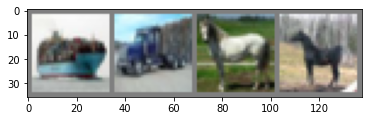

In [ ]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 5000 images per class in train set
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# 1k images per class in test set
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes_cifar = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter_cifar = iter(train_loader)
images_cifar, labels_cifar = next(dataiter_cifar) # **** made a change here: was dataiter.next() first ****

# show images
imshow(torchvision.utils.make_grid(images_cifar))

## KMNIST

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



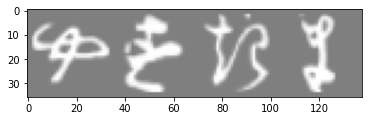

In [ ]:
# first we have to import the dataset
# for this we use the code from CIFAR above and adapt it

# KMNIST:
# 70k 28x28 greyscale images in 10 classes with 6000+1000 images per class

# they are already re-sized to 32x32 px and converted to RGB
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=3),
     transforms.Resize((32,32)),
     transforms.ToTensor()])
     #transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_kmnist = torchvision.datasets.KMNIST(root='./data', train=True, download=True, 
                                           transform=transform)

test_kmnist = torchvision.datasets.KMNIST(root='./data', train=False, download=True, 
                                          transform=transform)

# now we shorten kmnist train loader to match cifar

first5k = list(range(0, 50000))
train_kmnist = torch.utils.data.Subset(train_kmnist, first5k)

k_train_loader = torch.utils.data.DataLoader(train_kmnist, batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)

k_test_loader = torch.utils.data.DataLoader(test_kmnist, batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=1)

classes_kmnist = ('お', 'き', 'す', 'っ',
           'な', 'は', 'ま', 'や', 'れ', 'を')

# this shows some items
dataiter_kmnist = iter(k_train_loader)
images_kmnist, labels_kmnist = next(dataiter_kmnist)

# show images
imshow(torchvision.utils.make_grid(images_kmnist))

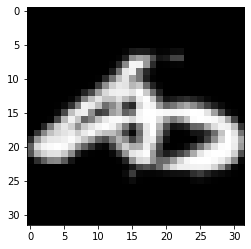

In [ ]:
# code that checks whether images are indeed 32x32px
from PIL import Image
from io import BytesIO

imgs = torch.stack([img_t for img_t, _ in train_kmnist], dim=3)

transs = transforms.ToPILImage()
imgg = transs(imgs[:,:,:,1])
plt.imshow(imgg, cmap="gray")
plt.show()

In [ ]:
# check if image indeed RGB?
imgg.getbands()

('R', 'G', 'B')

## Merging the Datasets
Later on, we need a dataset containing both CIFAR-10 and KMNIST images. This dataset is created here.

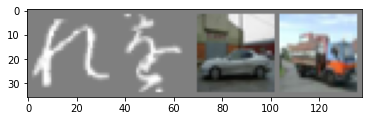

In [ ]:
# lets just try to combine both
train_both = torch.utils.data.ConcatDataset([train_dataset, train_kmnist])
test_both = torch.utils.data.ConcatDataset([test_dataset, test_kmnist])

# now we can create the dataloaders
both_train_loader = torch.utils.data.DataLoader(train_both, batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)
both_test_loader = torch.utils.data.DataLoader(test_both, batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=1)

both_classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck',
                'お', 'き', 'す', 'っ',
                'な', 'は', 'ま', 'や', 'れ', 'を')

# this shows some items
dataiter_mixed = iter(both_train_loader)
images_mixed, labels_mixed = next(dataiter_mixed)

# show images
imshow(torchvision.utils.make_grid(images_mixed))

# **Network definition**

Here we define a modified of Loeber´s net which is more similar to
the net architecture of Hannagan et al. (2021)

In [ ]:
# simpler Version of Hanngan et al.
# their code is here: https://github.com/THANNAGA/Origins-of-VWFA/blob/master/clean_cornets.py

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # this defines each layer; conv is convolutional, pool is pooling, fc is fully connected

### POOLING LAYER; only defined once i guess
        self.pool = nn.MaxPool2d(2, # kernel size
                                 2  # stride
                                 )

### CONV LAYERS
        self.conv1 = nn.Conv2d(3, # 3, because the images have three color channels (RGB)
                               16, # output channel size
                               5  # kernel size
                               )
        
        self.conv2 = nn.Conv2d(16, # input channel size; must be equal to last output channel size
                               32, # output channel size
                               3 # kernel is now 3
                               )

        self.conv3 = nn.Conv2d(32, # input channel size; must be equal to last output channel size
                               64, # output channel size
                               3 # kernel remains at 3
                               )
        
### DENSE LAYER
        self.fc1 = nn.Linear(64 * 2 * 2, # input size;
                             # follows a specific rule. see below
                             # first number should be output size of last layer

                             64 # output size
                             )

### FINAL OUTPUT LAYER
        self.fc2 = nn.Linear(64, # input size should match dense layer output
                             10 # output size should match the number of object classes
                             )


# (width - filter size)/stride + 1
# after conv1: (32-5)/1 + 1 = 28
# and then pooling halves this


    def forward(self, x):
        # -> n, 3, 32, 32
        # this is feed forward with relu activation function
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 16, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 32, 6, 6
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 64, 2, 2

        x = x.view(-1, 64 * 2 * 2)            # -> n, 128

        x = F.relu(self.fc1(x))               # -> n, 128
        x = self.fc2(x)                       # -> n, 10
        return x

# **First Paradigm: CIFAR-10 in Phase 1**

In the first paradigm, we always present CIFAR-10 in training phase 1. 

## Model V1

Here we apply the above model to train on CIFAR-10 in training phase. For the validation, we present only KMNIST in phase 2. Later on, we instead give the mixed dataset in phase 2 to, hopefully, prevent catastrophic interference.

In [ ]:
model_cifar = ConvNet().to(device)

# the loss is cross entropy, already includes softmax (like with Hannagan et al.)
criterion = nn.CrossEntropyLoss()
# this is the optimizer funcion, stochastic gradient descent in this case
optimizer = torch.optim.SGD(model_cifar.parameters(), lr=learning_rate)

Here we actually train the model, so running this cell takes a while.

In [ ]:
epoch_plot = np.array([0])
acc_c_then_k_cifar = np.array([10])
acc_c_then_k_kmnist = np.array([10])

#######################################
### training phase 1: only on cifar ###
#######################################

n_total_steps = len(train_loader)

for epoch in range(num_epochs_1):
    for i, (images_cifar, labels_cifar) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_cifar = images_cifar.to(device)
        labels_cifar = labels_cifar.to(device)

        # Forward pass
        outputs = model_cifar(images_cifar)
        loss = criterion(outputs, labels_cifar)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_cifar(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_k_cifar = np.append(acc_c_then_k_cifar,acc)
                print(f'Accuracy of the network on CIFAR10: {acc} %') # overall accuracy on cifar

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_cifar(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_k_kmnist = np.append(acc_c_then_k_kmnist,acc)
                print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy on KMNIST

########################################
### training phase 2: only on kmnist ###
########################################

# adjust the number of output nodes
model_cifar.fc = nn.Linear(84, 20)

n_total_steps = len(k_train_loader)

for epoch in range(num_epochs_2):
    for i, (images_kmnist, labels_kmnist) in enumerate(k_train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_kmnist = images_kmnist.to(device)
        labels_kmnist = labels_kmnist.to(device)

        # Forward pass
        outputs = model_cifar(images_kmnist)
        loss = criterion(outputs, labels_kmnist)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{num_epochs_1 + epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+num_epochs_1+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_cifar(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_k_cifar = np.append(acc_c_then_k_cifar,acc)
                print(f'Accuracy of the network: {acc} %') # overall accuracy

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_cifar(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_k_kmnist = np.append(acc_c_then_k_kmnist,acc)
                print(f'Accuracy of the network: {acc} %') # overall accuracy

print('Finished Training')
PATH = './cnn.pth'
torch.save(model_cifar.state_dict(), PATH)

Epoch [1/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 25.67 %
Accuracy of the network on KMNIST: 12.68 %
Epoch [2/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 35.95 %
Accuracy of the network on KMNIST: 11.81 %
Epoch [3/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 42.07 %
Accuracy of the network on KMNIST: 11.67 %
Epoch [4/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 47.04 %
Accuracy of the network on KMNIST: 11.7 %
Epoch [5/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 49.95 %
Accuracy of the network on KMNIST: 14.13 %
Epoch [6/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 53.79 %
Accuracy of the network on KMNIST: 15.3 %
Epoch [7/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 56.15 %
Accuracy of the network on KMNIST: 10.62 %
Epoch [8/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 57.44 %
Accuracy of the network on KMNIST: 12.34 %
Epoch [9/35], Step [12500/12500]
Accuracy 

This shows how learning proceeds during the training phase. 

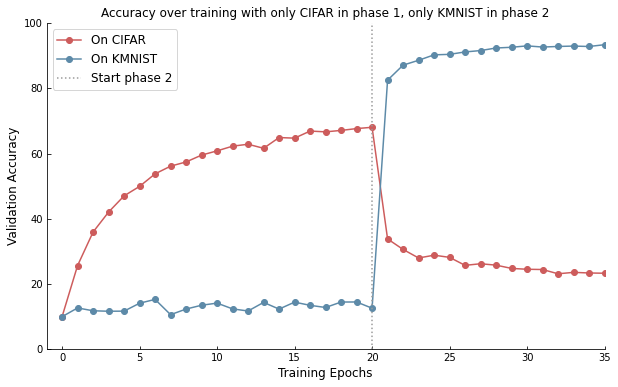

In [ ]:
# plot how learning evolves over epochs
plt.figure(figsize=(10,6))

plt.plot(epoch_plot,acc_c_then_k_cifar,'-o',label='On CIFAR',color='#CD5C5C')
plt.plot(epoch_plot,acc_c_then_k_kmnist,'-o',label='On KMNIST',color='#5D8AA8')
plt.axvline(x = num_epochs_1, color = '#9A9A9A',linestyle = ':', label = 'Start phase 2')
plt.legend(fontsize=12)

plt.xlabel('Training Epochs',size=12)
plt.ylabel('Validation Accuracy',size=12)
plt.title('Accuracy over training with only CIFAR in phase 1, only KMNIST in phase 2',size=12)

# sets limits of axes
plt.ylim(0,100)
plt.xlim(-1,num_epochs_1 + num_epochs_2)

# remove border around plot
for pos in ['right', 'top']:
  plt.gca().spines[pos].set_visible(False)

# have ticks face inward
plt.tick_params(axis = "both", direction = "in")

# set x-ticks
plt.xticks(range(0,(num_epochs_1 + num_epochs_2)+1,5))

plt.show()

## Model 1

The below code trains the model on the mixed dataset in phase 2. It thus produces one of the two main results of this project.

In [ ]:
model_cifar_mixed = ConvNet().to(device)

# the loss is cross entropy, already includes softmax (like with Hannagan et al.)
criterion = nn.CrossEntropyLoss()
# this is the optimizer funcion, stochastic gradient descent in this case
optimizer = torch.optim.SGD(model_cifar_mixed.parameters(), lr=learning_rate)

In [ ]:
epoch_plot = np.array([0])
acc_c_then_mixed_cifar = np.array([10])
acc_c_then_mixed_kmnist = np.array([10])

#######################################
### training phase 1: only on cifar ###
#######################################

n_total_steps = len(train_loader)

for epoch in range(num_epochs_1):
    for i, (images_cifar, labels_cifar) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_cifar = images_cifar.to(device)
        labels_cifar = labels_cifar.to(device)

        # Forward pass
        outputs = model_cifar_mixed(images_cifar)
        loss = criterion(outputs, labels_cifar)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_cifar_mixed(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_mixed_cifar = np.append(acc_c_then_mixed_cifar,acc)
                print(f'Accuracy of the network on CIFAR10: {acc} %') # overall accuracy on cifar

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_cifar_mixed(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_mixed_kmnist = np.append(acc_c_then_mixed_kmnist,acc)
                print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy on KMNIST

#######################################
### training phase 2: mixed dataset ###
#######################################

# adjust the number of output nodes
model_cifar_mixed.fc = nn.Linear(84, 20)

n_total_steps = len(both_train_loader)

for epoch in range(num_epochs_2):
    for i, (images_mixed, labels_mixed) in enumerate(both_train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_mixed = images_mixed.to(device)
        labels_mixed = labels_mixed.to(device)

        # Forward pass
        outputs = model_cifar_mixed(images_mixed)
        loss = criterion(outputs, labels_mixed)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{num_epochs_1 + epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+num_epochs_1+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_cifar_mixed(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_mixed_cifar = np.append(acc_c_then_mixed_cifar,acc)
                print(f'Accuracy of the network: {acc} %') # overall accuracy

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_cifar_mixed(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_c_then_mixed_kmnist = np.append(acc_c_then_mixed_kmnist,acc)
                print(f'Accuracy of the network: {acc} %') # overall accuracy

print('Finished Training')
PATH = './cnn.pth'
torch.save(model_cifar_mixed.state_dict(), PATH)

Epoch [1/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 27.83 %
Accuracy of the network on KMNIST: 10.07 %
Epoch [2/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 36.52 %
Accuracy of the network on KMNIST: 12.24 %
Epoch [3/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 43.23 %
Accuracy of the network on KMNIST: 11.83 %
Epoch [4/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 46.85 %
Accuracy of the network on KMNIST: 15.38 %
Epoch [5/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 49.89 %
Accuracy of the network on KMNIST: 14.92 %
Epoch [6/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 52.79 %
Accuracy of the network on KMNIST: 10.83 %
Epoch [7/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 55.31 %
Accuracy of the network on KMNIST: 10.55 %
Epoch [8/35], Step [12500/12500]
Accuracy of the network on CIFAR10: 57.54 %
Accuracy of the network on KMNIST: 11.85 %
Epoch [9/35], Step [12500/12500]
Accurac

This shows the accuracies of Model 1 as well as Model V1.

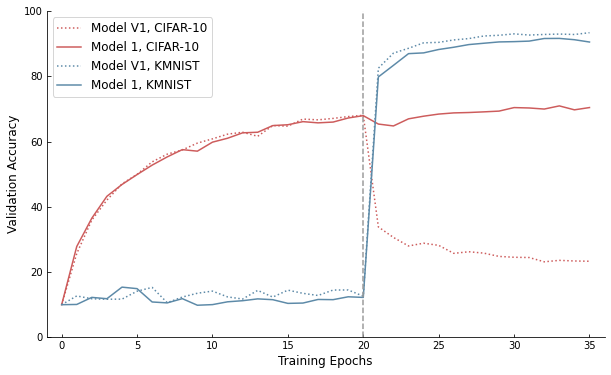

In [ ]:
# plot how learning evolves over epochs
plt.figure(figsize=(10,6))

plt.plot(epoch_plot,acc_c_then_k_cifar,':',label='Model V1, CIFAR-10',color='#CD5C5C')
plt.plot(epoch_plot,acc_c_then_mixed_cifar,'-',label='Model 1, CIFAR-10',color='#CD5C5C')
plt.plot(epoch_plot,acc_c_then_k_kmnist,':',label='Model V1, KMNIST',color='#5D8AA8')
plt.plot(epoch_plot,acc_c_then_mixed_kmnist,'-',label='Model 1, KMNIST',color='#5D8AA8')

plt.axvline(x = num_epochs_1, color = '#9A9A9A',linestyle = '--')
plt.legend(fontsize=12)

plt.xlabel('Training Epochs',size=12)
plt.ylabel('Validation Accuracy',size=12)
#plt.title('Accuracy over training for model 1',size=12)

# sets limits of axes
plt.ylim(0,100)
plt.xlim(-1,num_epochs_1 + num_epochs_2 + 1)

# remove border around plot
for pos in ['right', 'top']:
  plt.gca().spines[pos].set_visible(False)

# have ticks face inward
plt.tick_params(axis = "both", direction = "in")

# set x-ticks
plt.xticks(range(0,(num_epochs_1 + num_epochs_2)+1,5))

plt.show()

### Final accuracies per image class

In [ ]:
# calculating accuracies per image category for CIFAR
with torch.no_grad(): # don't need gradient calculations anymore here
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images_cifar, labels_cifar in test_loader:
        images_cifar = images_cifar.to(device)
        labels_cifar = labels_cifar.to(device)
        outputs = model_cifar_mixed(images_cifar)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels_cifar.size(0)
        n_correct += (predicted == labels_cifar).sum().item()
        
        for i in range(batch_size):
            label = labels_cifar[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on CIFAR: {acc} %') # overall accuracy

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes_cifar[i]}: {acc} %') # accuracy per class

# calculating accuracies per image category for KMNIST
with torch.no_grad(): # don't need gradient calculations anymore here
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images_kmnist, labels_kmnist in k_test_loader:
        images_kmnist = images_kmnist.to(device)
        labels_kmnist = labels_kmnist.to(device)
        outputs = model_cifar_mixed(images_kmnist)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels_kmnist.size(0)
        n_correct += (predicted == labels_kmnist).sum().item()
        
        for i in range(batch_size):
            label = labels_kmnist[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes_kmnist[i]}: {acc} %') # accuracy per class

Accuracy of the network on CIFAR: 70.44 %
Accuracy of plane: 75.5 %
Accuracy of car: 80.5 %
Accuracy of bird: 59.8 %
Accuracy of cat: 59.3 %
Accuracy of deer: 62.4 %
Accuracy of dog: 51.6 %
Accuracy of frog: 80.9 %
Accuracy of horse: 74.8 %
Accuracy of ship: 79.0 %
Accuracy of truck: 80.6 %
Accuracy of the network on KMNIST: 90.53 %
Accuracy of お: 92.8 %
Accuracy of き: 85.7 %
Accuracy of す: 88.4 %
Accuracy of っ: 97.9 %
Accuracy of な: 88.0 %
Accuracy of は: 86.7 %
Accuracy of ま: 90.4 %
Accuracy of や: 95.0 %
Accuracy of れ: 91.5 %
Accuracy of を: 88.9 %


# **Second Paradigm: KMNIST in Phase 1**

In the first paradigm, we always present KMNIST in training phase 1.

## Model V2

Next we first present KMNIST rather than CIFAR-10. Apart from the order in which stimuli are presented, the approach is identical to the first paradigm.

In [ ]:
model_kmnist = ConvNet().to(device)

# the loss is cross entropy, already includes softmax (like with Hannagan et al.)
criterion = nn.CrossEntropyLoss()
# this is the optimizer funcion, stochastic gradient descent in this case
optimizer = torch.optim.SGD(model_kmnist.parameters(), lr=learning_rate)

In [ ]:
epoch_plot = np.array([0])
acc_k_then_c_cifar = np.array([10])
acc_k_then_c_kmnist = np.array([10])

########################################
### training phase 1: only on kmnist ###
########################################

n_total_steps = len(k_train_loader)

for epoch in range(num_epochs_1):
    for i, (images_kmnist, labels_kmnist) in enumerate(k_train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_kmnist = images_kmnist.to(device)
        labels_kmnist = labels_kmnist.to(device)

        # Forward pass
        outputs = model_kmnist(images_kmnist)
        loss = criterion(outputs, labels_kmnist)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_kmnist(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_c_cifar = np.append(acc_k_then_c_cifar,acc)
                print(f'Accuracy of the network on CIFAR: {acc} %') # overall accuracy on cifar

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_kmnist(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_c_kmnist = np.append(acc_k_then_c_kmnist,acc)
                print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy on KMNIST

########################################
### training phase 2: only on cifar ###
########################################

# adjust the number of output units 
model_kmnist.fc = nn.Linear(84, 20)

n_total_steps = len(train_loader)

for epoch in range(num_epochs_2):
    for i, (images_cifar, labels_cifar) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_cifar = images_cifar.to(device)
        labels_cifar = labels_cifar.to(device)

        # Forward pass
        outputs = model_kmnist(images_cifar)
        loss = criterion(outputs, labels_cifar)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{num_epochs_1 + epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+num_epochs_1+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_kmnist(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_c_cifar = np.append(acc_k_then_c_cifar,acc)
                print(f'Accuracy of the network on CIFAR: {acc} %') # overall accuracy

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_kmnist(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_c_kmnist = np.append(acc_k_then_c_kmnist,acc)
                print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy

print('Finished Training')
PATH = './cnn.pth'
torch.save(model_kmnist.state_dict(), PATH)

Epoch [1/35], Step [12500/12500]
Accuracy of the network on CIFAR: 8.77 %
Accuracy of the network on KMNIST: 64.01 %
Epoch [2/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.56 %
Accuracy of the network on KMNIST: 75.95 %
Epoch [3/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.76 %
Accuracy of the network on KMNIST: 80.39 %
Epoch [4/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.84 %
Accuracy of the network on KMNIST: 82.65 %
Epoch [5/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.63 %
Accuracy of the network on KMNIST: 85.26 %
Epoch [6/35], Step [12500/12500]
Accuracy of the network on CIFAR: 10.3 %
Accuracy of the network on KMNIST: 87.58 %
Epoch [7/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.57 %
Accuracy of the network on KMNIST: 86.91 %
Epoch [8/35], Step [12500/12500]
Accuracy of the network on CIFAR: 10.57 %
Accuracy of the network on KMNIST: 89.48 %
Epoch [9/35], Step [12500/12500]
Accuracy of the network on CIF

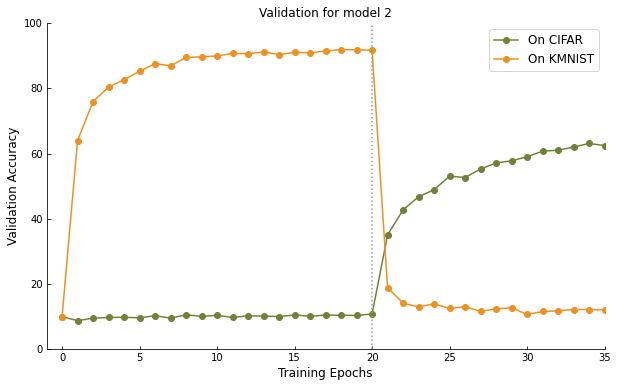

In [ ]:
# plot how learning evolves over epochs
plt.figure(figsize=(10,6))

plt.plot(epoch_plot,acc_k_then_c_cifar,'-o',label='On CIFAR',color='#708238')
plt.plot(epoch_plot,acc_k_then_c_kmnist,'-o',label='On KMNIST',color='#ED9121')
plt.axvline(x = num_epochs_1, color = '#9A9A9A',linestyle = ':')
plt.legend(fontsize=12)

plt.xlabel('Training Epochs',size=12)
plt.ylabel('Validation Accuracy',size=12)
plt.title('Validation for model 2',size=12)

# sets limits of axes
plt.ylim(0,100)
plt.xlim(-1,num_epochs_1 + num_epochs_2)

# remove border around plot
for pos in ['right', 'top']:
  plt.gca().spines[pos].set_visible(False)

# have ticks face inward
plt.tick_params(axis = "both", direction = "in")

# set x-ticks
plt.xticks(range(0,num_epochs_1 + num_epochs_2 +1,5))

plt.show()

## Model 2

Next we present the mixed dataset in phase 2.

In [ ]:
model_kmnist_mixed = ConvNet().to(device)

# the loss is cross entropy, already includes softmax (like with Hannagan et al.)
criterion = nn.CrossEntropyLoss()
# this is the optimizer funcion, stochastic gradient descent in this case
optimizer = torch.optim.SGD(model_kmnist_mixed.parameters(), lr=learning_rate)

In [ ]:
epoch_plot = np.array([0])
acc_k_then_mixed_cifar = np.array([10])
acc_k_then_mixed_kmnist = np.array([10])

########################################
### training phase 1: only on kmnist ###
########################################

n_total_steps = len(k_train_loader)

for epoch in range(num_epochs_1):
    for i, (images_kmnist, labels_kmnist) in enumerate(k_train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_kmnist = images_kmnist.to(device)
        labels_kmnist = labels_kmnist.to(device)

        # Forward pass
        outputs = model_kmnist_mixed(images_kmnist)
        loss = criterion(outputs, labels_kmnist)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_kmnist_mixed(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_mixed_cifar = np.append(acc_k_then_mixed_cifar,acc)
                print(f'Accuracy of the network on CIFAR: {acc} %') # overall accuracy on cifar

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_kmnist_mixed(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_mixed_kmnist = np.append(acc_k_then_mixed_kmnist,acc)
                print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy on KMNIST

###############################
### training phase 2: mixed ###
###############################

# adjust number of output units
model_kmnist_mixed.fc = nn.Linear(84, 20)

n_total_steps = len(both_train_loader)

for epoch in range(num_epochs_2):
    for i, (images_mixed, labels_mixed) in enumerate(both_train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images_mixed = images_mixed.to(device)
        labels_mixed = labels_mixed.to(device)

        # Forward pass
        outputs = model_kmnist_mixed(images_mixed)
        loss = criterion(outputs, labels_mixed)

        # Backward and optimize
        optimizer.zero_grad() # set all the gradients to zero before starting backward prop anew
        loss.backward()
        optimizer.step()

        if (i+1) % n_total_steps == 0:
            print (f'Epoch [{num_epochs_1 + epoch+1}/{num_epochs_1 + num_epochs_2}], Step [{i+1}/{n_total_steps}]') #, Loss: {loss.item():.4f}')
            epoch_plot = np.append(epoch_plot,epoch+num_epochs_1+1)

            # print accuracy on CIFAR after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_cifar, labels_cifar in test_loader:
                    images_cifar = images_cifar.to(device)
                    labels_cifar = labels_cifar.to(device)
                    outputs = model_kmnist_mixed(images_cifar)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_cifar.size(0)
                    n_correct += (predicted == labels_cifar).sum().item()
        
                    for i in range(batch_size):
                        label = labels_cifar[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_mixed_cifar = np.append(acc_k_then_mixed_cifar,acc)
                print(f'Accuracy of the network on CIFAR: {acc} %') # overall accuracy

            # print accuracy on KMNIST after each epoch step
            with torch.no_grad(): # don't need gradient calculations anymore here
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                for images_kmnist, labels_kmnist in k_test_loader:
                    images_kmnist = images_kmnist.to(device)
                    labels_kmnist = labels_kmnist.to(device)
                    outputs = model_kmnist_mixed(images_kmnist)
                   # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels_kmnist.size(0)
                    n_correct += (predicted == labels_kmnist).sum().item()
        
                    for i in range(batch_size):
                        label = labels_kmnist[i]
                        pred = predicted[i]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1

                acc = 100.0 * n_correct / n_samples
                acc_k_then_mixed_kmnist = np.append(acc_k_then_mixed_kmnist,acc)
                print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy

print('Finished Training')
PATH = './cnn.pth'
torch.save(model_kmnist_mixed.state_dict(), PATH)

Epoch [1/35], Step [12500/12500]
Accuracy of the network on CIFAR: 8.23 %
Accuracy of the network on KMNIST: 48.94 %
Epoch [2/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.35 %
Accuracy of the network on KMNIST: 70.33 %
Epoch [3/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.33 %
Accuracy of the network on KMNIST: 79.86 %
Epoch [4/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.45 %
Accuracy of the network on KMNIST: 83.48 %
Epoch [5/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.25 %
Accuracy of the network on KMNIST: 84.66 %
Epoch [6/35], Step [12500/12500]
Accuracy of the network on CIFAR: 9.3 %
Accuracy of the network on KMNIST: 85.27 %
Epoch [7/35], Step [12500/12500]
Accuracy of the network on CIFAR: 10.04 %
Accuracy of the network on KMNIST: 86.79 %
Epoch [8/35], Step [12500/12500]
Accuracy of the network on CIFAR: 10.04 %
Accuracy of the network on KMNIST: 88.3 %
Epoch [9/35], Step [12500/12500]
Accuracy of the network on CIFA

This shows the results for Model 2 and Model V2.

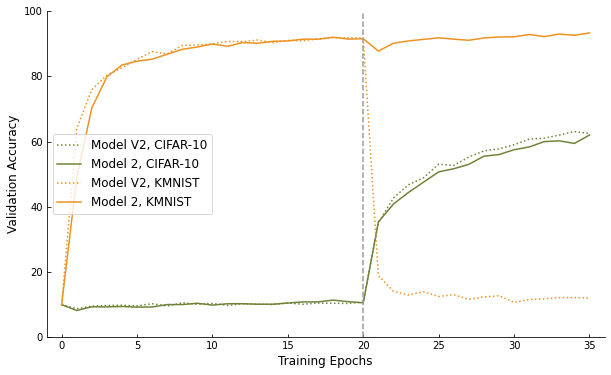

In [ ]:
# plot how learning evolves over epochs
plt.figure(figsize=(10,6))

plt.plot(epoch_plot,acc_k_then_c_cifar,':',label='Model V2, CIFAR-10',color='#708238')
plt.plot(epoch_plot,acc_k_then_mixed_cifar,'-',label='Model 2, CIFAR-10',color='#708238')
plt.plot(epoch_plot,acc_k_then_c_kmnist,':',label='Model V2, KMNIST',color='#ED9121')
plt.plot(epoch_plot,acc_k_then_mixed_kmnist,'-',label='Model 2, KMNIST',color='#ED9121')

plt.axvline(x = num_epochs_1, color = '#9A9A9A',linestyle = '--')
plt.legend(fontsize=12)

plt.xlabel('Training Epochs',size=12)
plt.ylabel('Validation Accuracy',size=12)
#plt.title('Accuracy over training for model 2',size=12)

# sets limits of axes
plt.ylim(0,100)
plt.xlim(-1,num_epochs_1 + num_epochs_2 + 1)

# remove border around plot
for pos in ['right', 'top']:
  plt.gca().spines[pos].set_visible(False)

# have ticks face inward
plt.tick_params(axis = "both", direction = "in")

# set x-ticks
plt.xticks(range(0,(num_epochs_1 + num_epochs_2)+1,5))

plt.show()

### Final accuracies per image class

In [ ]:
# calculating accuracies per image category for CIFAR
with torch.no_grad(): # don't need gradient calculations anymore here
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images_cifar, labels_cifar in test_loader:
        images_cifar = images_cifar.to(device)
        labels_cifar = labels_cifar.to(device)
        outputs = model_kmnist_mixed(images_cifar)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels_cifar.size(0)
        n_correct += (predicted == labels_cifar).sum().item()
        
        for i in range(batch_size):
            label = labels_cifar[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on CIFAR: {acc} %') # overall accuracy

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes_cifar[i]}: {acc} %') # accuracy per class

# calculating accuracies per image category for KMNIST
with torch.no_grad(): # don't need gradient calculations anymore here
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images_kmnist, labels_kmnist in k_test_loader:
        images_kmnist = images_kmnist.to(device)
        labels_kmnist = labels_kmnist.to(device)
        outputs = model_kmnist_mixed(images_kmnist)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels_kmnist.size(0)
        n_correct += (predicted == labels_kmnist).sum().item()
        
        for i in range(batch_size):
            label = labels_kmnist[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on KMNIST: {acc} %') # overall accuracy

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes_kmnist[i]}: {acc} %') # accuracy per class

Accuracy of the network on CIFAR: 62.02 %
Accuracy of plane: 70.1 %
Accuracy of car: 80.5 %
Accuracy of bird: 43.5 %
Accuracy of cat: 38.7 %
Accuracy of deer: 56.9 %
Accuracy of dog: 47.4 %
Accuracy of frog: 75.4 %
Accuracy of horse: 69.0 %
Accuracy of ship: 75.0 %
Accuracy of truck: 63.7 %
Accuracy of the network on KMNIST: 93.32 %
Accuracy of お: 93.4 %
Accuracy of き: 91.2 %
Accuracy of す: 88.9 %
Accuracy of っ: 95.5 %
Accuracy of な: 91.0 %
Accuracy of は: 91.8 %
Accuracy of ま: 96.6 %
Accuracy of や: 93.7 %
Accuracy of れ: 95.5 %
Accuracy of を: 95.6 %
